# Mangle spectra

In [1]:
import os
#COCO_PATH=os.environ['COCO_PATH']
COCO_PATH="/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates/"
DATALC_PATH = COCO_PATH+"/Inputs/Photometry/4_LCs_late_extrapolated/"
DATASPEC_PATH = COCO_PATH+"/Inputs/Spectroscopy/"

DATAINFO_PATH= COCO_PATH+"Inputs/SNe_Info/"
FILTER_PATH = COCO_PATH+"Inputs/Filters/"

OUTPUT_DIR = COCO_PATH+"Outputs/"

import sys
sys.path.insert(0, COCO_PATH+'what_the_flux/')
import what_the_flux as wtf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy import interpolate
from scipy import integrate
import scipy.optimize as opt

import george
from george.kernels import ExpSquaredKernel, ConstantKernel, Matern32Kernel

import matplotlib.cm as cm
import scipy
%matplotlib inline

In [3]:
color_dict = {'Bessell_U': 'blue', 'Bessell_B': 'royalblue','Bessell_V':  'limegreen',
              'Bessell_R':  'red', 'Bessell_I':  'mediumvioletred',
              'sdss_g':'darkgreen','ptf_g':'darkgreen', "sdss_g'":'darkgreen','sdss_i':'indianred',
              "sdss_i'":'indianred','sdss_r': 'darkred', "sdss_r'":'darkred','sdss_z':'sienna', "sdss_z'":'sienna',
              'sdss_u': 'darkblue', "sdss_u'": 'darkblue', 'Y':'salmon','H':'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown', 'swift_UVW1':'indigo', 'swift_UVW2':'darkblue',
               'swift_UVM2':'darkmagenta','swift_U':'plum','swift_V':'teal','swift_B':'powderblue'}

mark_dict = {'Bessell_U': 'o','Bessell_B': 'o', 'Bessell_V':'o', 'Bessell_R':'o', 'Bessell_I': 'o', 
             'sdss_g':'s','ptf_g':'s', "sdss_g'":'s', 'sdss_i':'s', "sdss_i'":'s',
                'sdss_r':'s', "sdss_r'":'s', 'sdss_z':'s', "sdss_z'":'s', 'sdss_u': 's', "sdss_u'": 's',
                'Y':  'o','H':  'o', 'J':  'o', 'Ks':  'o','K':  'o',
                'swift_UVW1':'D', 'swift_UVW2':'D', 'swift_UVM2':'D', 'swift_U':'D',
                'swift_V':'D', 'swift_B':'D'}

CSP_SNe = ['SN2004fe', 'SN2005bf', 'SN2006V', 'SN2007C', 'SN2007Y',
           'SN2009bb',  'SN2008aq', 'SN2006T', 'SN2004gq', 'SN2004gt',
           'SN2004gv','SN2006ep', 'SN2008fq', 'SN2006aa']

exclude_filt = ['H', 'J', 'K', 'Ks','KS', 'Y']
#exclude_filt = ['KS']

In [4]:
def err_to_log10(flux, err_flux):
    flux=np.array(flux, dtype=float)
    err_flux=np.array(err_flux, dtype=float)
    return 1./np.log(10.) * err_flux/flux

def err_from_log10(logflux, logerr_flux):
    return np.log(10.) * 10**logflux * logerr_flux



In [5]:
def calc_lam_avg(wls, transmission):
    return (integrate.trapezoid(transmission*wls, wls)/\
            integrate.trapezoid(transmission, wls))

def calc_lam_eff(wls, transmission, flux):
    return (integrate.trapezoid(transmission*flux*wls, wls)/\
            integrate.trapezoid(transmission*flux, wls))

def prop_err_div(x,y,sig_x,sig_y):
    return ((sig_x/y)**2  +  ((x*sig_y)/y**2)**2 )**0.5

### Build the Class

In [6]:
class SingleSpectrumClass():
    """Class to load and mangle a single spectrum:
    """
    
    def __init__(self, snname, spec_file=None, verbose=False):
        """
        """
        self.snname = snname
        self.check_results_folder()
        
        if spec_file is None:
            print ("Choose one spec_file from this list:")
            print (len(self.get_spec_list()))
        else:
            self.spec_file = spec_file
            self.load_manglingfile()

    def check_results_folder(self):
        results_directory = OUTPUT_DIR+'/%s/'%self.snname
        if not os.path.exists(results_directory):
            print ("I cant mangle a spectrum if I theres no fitted LC yet")
        else: self.results_mainpath = results_directory

    def load_manglingfile(self):
        if not hasattr(self, "results_mainpath"):
            self.check_results_folder()
        else:
            mangling_file = OUTPUT_DIR+'/%s/'%self.snname+'fitted_phot4mangling_%s.dat'%self.snname
            if not os.path.isfile(mangling_file):
                print ("I need the file with fitted photometry in order to mangle a spectrum")
            else:
                phot4mangling = pd.read_csv(mangling_file, sep='\t')
                #print (phot4mangling)#self.phot4mangling = 
                self.phot4mangling = (phot4mangling[phot4mangling['spec_file']== self.spec_file])
                self.avail_filters = [col.replace('_fitflux','') for col in phot4mangling.columns\
                                      if col[-8:]=='_fitflux']
                
    def load_raw_spec(self):
        if not hasattr(self, "phot4mangling"):
            self.load_manglingfile()
        else:
            raw_spec = np.genfromtxt(self.spec_file,\
                                     dtype=None, encoding="utf-8", names=['wls', 'flux', 'fluxerr'])
            raw_spec = raw_spec[(~np.isnan(raw_spec['flux']))&(~np.isnan(raw_spec['wls']))]
            raw_spec['flux'] = raw_spec['flux']
            self.raw_spec = raw_spec
        return raw_spec
        
    def get_spec_list(self, verbose=False):
        phase_list_file = DATASPEC_PATH + '2_spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None, encoding="utf-8")
            spec_list = parse_phase['f2']
            mjd_list = parse_phase['f0']
            mjd_fake_phase = parse_phase['f1']
            if verbose: 
                for mjd,i in zip(spec_list, mjd_list): 
                    print (mjd, i)
            return np.array(spec_list)
        except: 
            print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
  
    def check_spec_manglingphot(self):
        all_specs = self.get_spec_list()
        mangling_file = OUTPUT_DIR+'/%s/'%self.snname+'fitted_phot4mangling_%s.dat'%self.snname
        phot4mangling = pd.read_csv(mangling_file, sep='\t')
        for spec_file in all_specs:
            file_name = spec_file
            mask = phot4mangling['spec_file'].values == file_name
            if len(phot4mangling[mask])==0:
                print ('There.s no magnling photometry fro this. Are you sure nothing went wrong in the step 4_LCfit?', spec_file)

    def create_mangledspec_folder(self):
        mangledspec_directory = OUTPUT_DIR+'/%s/'%self.snname+'/mangled_spectra/'
        if not os.path.exists(mangledspec_directory):
            os.makedirs(mangledspec_directory)
        self.mangledspec_path = mangledspec_directory

    
    def band_flux(self, filter_name, type_spec2use=False):
        """ type_spec2use choose one among: 
                raw_spec, 
                mangled  """
        
        if (not hasattr(self, 'raw_spec'))&(type_spec2use=='raw_spec'):
            print ("Load the spectrum first calling self.load_raw_spec() and self.break_degeneracy()")
        elif (hasattr(self, 'raw_spec'))&(type_spec2use=='raw_spec'):
              spec_flux = self.raw_spec
              #print("raw_spec shape:", self.raw_spec.shape)
              #print("raw_spec type:", type(self.raw_spec))
              #print("raw_spec contents:", self.raw_spec[:5])
        elif (not hasattr(self, 'mangled_spec'))&(type_spec2use=='mangled'):
            print ("Mangled spectrum not available. Mangle the spectrum first calling self.mangle_spectrum()")
        elif (hasattr(self, 'mangled_spec'))&(type_spec2use=='mangled'):
              spec_flux = self.mangled_spec
        #print("Shape of spec_flux:", spec_flux.shape)
        
        #print ('type_spec2use', type_spec2use, min(spec_flux['flux']))

        if 'swift' in filter_name:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Swift/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        elif self.snname in CSP_SNe:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Site3_CSP/%s.txt'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        else:
            filt_transm = np.genfromtxt(FILTER_PATH+'/GeneralFilters/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])

        min_wls = min(filt_transm['wls'])
        max_wls = max(filt_transm['wls'])
        
        lam_avg = calc_lam_avg(filt_transm['wls'], filt_transm['flux']) 

        cut_spec = (spec_flux['wls']>min_wls)&\
                     (spec_flux['wls']<max_wls)
        cut_raw_spec = spec_flux[cut_spec].copy()
        #print("spec_flux shape:", spec_flux.shape)
        
        filt_transm_interp_func = interpolate.interp1d(filt_transm['wls'], 
                                                       filt_transm['flux'], 
                                                       kind='linear')
        filt_transm_interp = filt_transm_interp_func(cut_raw_spec['wls'])
        filt_transm_interp_xLambda = filt_transm_interp*cut_raw_spec['wls']
        
        lam_eff = calc_lam_eff(cut_raw_spec['wls'], 
                                        filt_transm_interp, 
                                        cut_raw_spec['flux']) 

        raw_phot = integrate.trapezoid(filt_transm_interp_xLambda*cut_raw_spec['flux'], cut_raw_spec['wls'])/\
                 integrate.trapezoid(filt_transm_interp_xLambda, cut_raw_spec['wls'])
        raw_phot_err = (integrate.trapezoid((filt_transm_interp_xLambda*cut_raw_spec['fluxerr'])**2,
                                        cut_raw_spec['wls']))**0.5/\
                 integrate.trapezoid(filt_transm_interp_xLambda, cut_raw_spec['wls'])

        if type_spec2use=='mangled':  
            return lam_eff, raw_phot
        else: 
            return lam_avg, lam_eff, raw_phot, raw_phot_err, min_wls, max_wls
        
        
    def mangle_spectrum_function(self, show=False):
        if (not hasattr(self, 'mangledspec_path')):
            self.create_mangledspec_folder()
        elif (not hasattr(self, 'raw_spec')):
            self.load_raw_spec()

        ratios=[]
        ratios_err=[]
        fitted_phot_list=[]
        fitted_photerr_list=[]
        wls_eff=[]
        used_filters=[]
        
        outMJD_ratios=[]
        outMJD_ratios_err=[]
        outMJD_fitted_phot_list=[]
        outMJD_fitted_photerr_list=[]
        outMJD_wls_eff=[]
        outMJD_used_filters=[]

        outwls_filters_wls_eff=[]
        outwls_filters=[]
        outwls_fitted_phot_list=[]; outwls_fitted_photerr_list=[]

        for filt in self.avail_filters:
            fitted_phot = self.phot4mangling['%s_fitflux'%filt].values[0]
            fitted_phot_err = self.phot4mangling['%s_fitfluxerr'%filt].values[0]
            inMJDrange_pnt = self.phot4mangling['%s_inrange'%filt].values[0]

            lam_avg, lam_eff, raw_phot, raw_phot_err, min_wls, max_wls = self.band_flux(filt, type_spec2use='raw_spec')

            #added these lines before if statement:
            #print("Checking filters:")
            #condition = (lam_avg > min(self.raw_spec['wls'])) & (lam_avg < max(self.raw_spec['wls'])) & (fitted_phot > 0.)
            condition = (max_wls > min(self.raw_spec['wls'])) & (min_wls < max(self.raw_spec['wls'])) & (fitted_phot > 0.)

            #print(f"\nFilter: {filt}")
            #print(f"  - Fitted Phot: {fitted_phot}")
            #print(f"  - Raw Phot: {raw_phot}")
            #print(f"  - Min Wavelength: {min(self.raw_spec['wls'])}")
            #print(f"  - Max Wavelength: {max(self.raw_spec['wls'])}")
            #print(f"  - lam_avg: {lam_avg}")
            #print(f"  - lam_eff: {lam_eff}")
            #print(f"  - min_wls: {min_wls}, max_wls: {max_wls}")
            #print(f"  - Condition: {condition}")
            
            if filt in ['Bessell_R', 'sdss_z', "sdss_z'"]:
                #condition = (lam_avg>min(self.raw_spec['wls']))&\
                    #(lam_avg<max(self.raw_spec['wls']))&(fitted_phot>0.)
                condition = (max_wls > min(self.raw_spec['wls'])) & (min_wls < max(self.raw_spec['wls'])) & (fitted_phot > 0.)
            else:
                #condition = (lam_avg>min(self.raw_spec['wls']))&\
                    #(lam_avg<max(self.raw_spec['wls']))&(fitted_phot>0.)
                condition = (max_wls > min(self.raw_spec['wls'])) & (min_wls < max(self.raw_spec['wls'])) & (fitted_phot > 0.)
            if (not inMJDrange_pnt):
                outMJD_fitted_phot_list.append(fitted_phot)
                outMJD_fitted_photerr_list.append(fitted_phot_err)
                outMJD_ratios.append(fitted_phot/raw_phot)
                outMJD_ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err, 0.) )
                outMJD_wls_eff.append(lam_eff)
                outMJD_used_filters.append(filt)
            else:
                if condition:
                    fitted_phot_list.append(fitted_phot)
                    fitted_photerr_list.append(fitted_phot_err)
                    ratios.append(fitted_phot/raw_phot)
                    ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err, 0.) )
                    wls_eff.append(lam_eff)
                    used_filters.append(filt)
                else:
                    if (fitted_phot>0.):
                        outwls_filters.append(filt)
                        outwls_filters_wls_eff.append(lam_avg)
                        outwls_fitted_phot_list.append(fitted_phot)
                        outwls_fitted_photerr_list.append(fitted_phot_err)
        ratios = np.array(ratios)
        wls_eff = np.array(wls_eff)
        ratios_err = np.array(ratios_err)
        used_filters = np.array(used_filters)

        if len(ratios)<1:
            print ('Impossible to mangle ',
                   self.spec_file,
                  'used', used_filters, '\nUnused', outMJD_used_filters)
            return None
        else:
            if len(self.raw_spec['wls'])>10**4:
                # GP struggle to handle such a big number of points
                int_fraction = int(len(self.raw_spec['wls'])/5000.)
                print ('This spectrum has a huge amount of data points(%i), Im chopping a %i th of them'%(len(self.raw_spec['wls']), int_fraction))
                full_wls = self.raw_spec['wls'][::int_fraction]
            else:
                full_wls = self.raw_spec['wls']
            norm_wls = np.median(full_wls)
            full_wls_normed = full_wls/norm_wls
            wls_eff_normed = np.array(wls_eff)/norm_wls
            
            offset=1.
            norm = np.mean(ratios)
            ratios_normed = np.array(ratios)/norm-offset
            ratios_err_normed = np.array(ratios_err)/norm

            def ll(p):
                gp.set_parameter_vector(p)
                scale = np.exp(gp.get_parameter_dict()['kernel:k2:metric:log_M_0_0'])
                if scale<0.09:
                    return np.inf
                else:
                    return -gp.lnlikelihood(ratios_normed, quiet=False)#
            def grad_ll(p):
                gp.set_parameter_vector(p)
                return -gp.grad_lnlikelihood(ratios_normed, quiet=False)
         
            k= np.var(ratios_normed)*Matern32Kernel(0.2)
     
            wls_eff_normedT = np.atleast_2d(wls_eff_normed).T
            gp = george.GP(k)
            gp.compute(wls_eff_normedT, (ratios_err_normed))
            p0=gp.get_parameter_vector()
            
            results = opt.minimize(ll, p0, jac=grad_ll)
            #print ('SCALE', np.exp(results.x))
            #print ('#######', wls_eff,'\n', ratios,'\n', ratios_err,'\n', ratios_normed,'\n', norm)
            gp.set_parameter_vector(results.x)
            mu, cov = gp.predict(ratios_normed, full_wls_normed)
            std = np.sqrt(np.diag(cov))
            
            spec_number = self.phot4mangling.spec_mjd.values[0]#self.phot4mangling.index.values[0]
            
            fig=plt.figure(1, figsize=(14,6))
            plt.rc('font', family='serif')
            plt.rc('xtick', labelsize=13)
            plt.rc('ytick', labelsize=13)
            ax1 = plt.subplot2grid((5,1), (0,0), rowspan=2)
            for f,w,r,rerr in zip(used_filters, wls_eff,\
                                  ratios, ratios_err):
                if 'swift' in f:
                    flabel = f.split('_')[1]+'(Swift)'
                else: 
                    #added this stuff statement
                    print(f"Checking filter name: {f}")
                    if '_' in f:
                        flabel = f.split('_')[1]
                    else:
                        print(f"Unexpected filter format: {f}")  # Debugging output
                        flabel = f  # Just use the filter name directly
                    #flabel = f.split('_')[1]
                ax1.errorbar(w, r, yerr=rerr, marker=mark_dict[f], ms=8,
                             mfc= color_dict[f], mec=color_dict[f], linestyle='None',\
                         ecolor= color_dict[f], label='%s'%flabel)
            ax1.errorbar(full_wls, norm*(mu+offset), color='orange',label='Mangling\nfunction')
            ax1.fill_between(full_wls, norm*((mu+offset)-std), norm*((mu+offset)+std), color='orange',alpha=0.3)
            ax1.set_ylabel('Photometric Flux/\nSynthetic Flux', fontsize=13)

            ax1.set_title('Example of mangling using a spectrum of %s'%self.snname,fontsize=15)

            ax1.set_ylim(min(ratios)*(0.9), max(ratios)*(1.1))
            #changed this
            #ax1.set_xlim(1600., 10300.)
            plt.tick_params(axis='x', labelbottom=False)
            ax1.legend(ncol=2, fontsize=12, loc='best')
            if len(self.raw_spec['wls'])>10**4:
                # GP struggle to handle such a big number of points
                mu_full = np.interp(self.raw_spec['wls'], self.raw_spec['wls'][::int_fraction], mu)
                std_full = np.interp(self.raw_spec['wls'], self.raw_spec['wls'][::int_fraction], std)
            else:
                mu_full = mu
                std_full = std

            mangled_spec = self.raw_spec['flux']*norm*(mu_full+offset)
            mangled_spec_err = ((norm*(std_full)*self.raw_spec['flux'])**2 + \
                                ((norm*(mu_full+offset))*self.raw_spec['fluxerr'])**2)**0.5

            self.mangled_spec = np.array([a for a in zip(self.raw_spec['wls'], mangled_spec, mangled_spec_err)],
                                         dtype=[('wls', '<f8'), ('flux', '<f8'), ('fluxerr', '<f8')])
            self.fitted_phot_dict = {'eff_wls':wls_eff, 'fitted_phot':fitted_phot_list,\
                                     'fitted_phot_err':fitted_photerr_list, 'used_filters': used_filters}
            self.mangling_mask = norm*(mu_full+offset)
            mangled_phot_list=[]
            for filt in used_filters:
                lam_eff, mangled_phot = self.band_flux(filt, type_spec2use='mangled')
                mangled_phot_list.append(mangled_phot)
            self.magled_photometry_dict = {'eff_wls': wls_eff, 'fitted_phot': mangled_phot_list,\
                                           'used_filters': used_filters}
            
            ax2 = plt.subplot2grid((5,1), (2,0), rowspan=3)
            ax2.errorbar(self.mangled_spec['wls'], self.mangled_spec['flux'],\
                         lw=0.9, color='k', label='Mangled Spectrum')
            mask_neg = self.mangled_spec['flux']<0.
            ax2.errorbar(self.mangled_spec['wls'][mask_neg], self.mangled_spec['flux'][mask_neg],\
                         lw=3.9, color='m', label='Mangled Spectrum')
            ax2.errorbar(self.raw_spec['wls'], self.raw_spec['flux']*norm,\
                         lw=0.6, color='r', alpha=1, label='Uncalibrated Spectrum\n+ Offset')
            ax2.errorbar(np.concatenate([self.fitted_phot_dict['eff_wls'],outwls_filters_wls_eff]), 
                         np.concatenate([self.fitted_phot_dict['fitted_phot'], outwls_fitted_phot_list]),\
                         yerr = np.concatenate([self.fitted_phot_dict['fitted_phot_err'], 
                                                outwls_fitted_photerr_list]),
                         marker='o', mfc='grey', mec='grey',ms=7, 
                         ecolor='grey', linestyle='None', label='Photometric flux\nfrom LC fitting')

            ax2.errorbar(self.magled_photometry_dict['eff_wls'], self.magled_photometry_dict['fitted_phot'],\
                         marker='^', mfc='r', mec='r', linestyle='None', ms=7,
                         label='Flux synthesized\nfrom mangled spec')
                          
            ax2.fill_between(self.mangled_spec['wls'], self.mangled_spec['flux']-self.mangled_spec['fluxerr'],\
                             self.mangled_spec['flux']+self.mangled_spec['fluxerr'], color='grey',alpha=0.3)

            ax2.set_ylabel(r'Flux ($\mathrm{erg}$ $\mathrm{s^{-1} cm^{-2}} \mathrm{\AA} $)', fontsize=13)
            ax2.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=13)
            #changed this
            #ax2.set_xlim(1600., 10300.)
            ax2.legend(ncol=1, fontsize=13, loc='upper right')
            plt.subplots_adjust(hspace=0.3, wspace=0.1)
            fig.savefig(self.mangledspec_path+'%.6f_mangled_spec.pdf'%spec_number, bbox_inches='tight')
            if show: plt.show()
            plt.close(fig)
            self.save_mangled_spectrum()
            return {'wls': self.raw_spec['wls'] , 'flux': mangled_spec}
    
    def get_diff_FittedMangled_phot(self):
        fitted_phot = np.array(self.fitted_phot_dict['fitted_phot'])
        fitted_phot_err = np.array(self.fitted_phot_dict['fitted_phot_err'])
        mangled_phot = np.array(self.magled_photometry_dict['fitted_phot'])
        diff_mag = -2.5*np.log10(mangled_phot/fitted_phot)
        
        def err_fromFlux_toMag(flux, err_flux):
            flux = np.array(flux, dtype=float)
            err_flux = np.array(err_flux, dtype=float)
            return 2.5/np.log(10.) * err_flux/flux
    
        fitted_phot_err_mag = err_fromFlux_toMag(fitted_phot, fitted_phot_err)
        discrepancy_mag = diff_mag/fitted_phot_err_mag
        return self.magled_photometry_dict['used_filters'], diff_mag, discrepancy_mag 

    def save_mangled_spectrum(self):
    
        if (not hasattr(self, 'mangled_spec')):
            print ("Mangled spectrum not available. Mangle the spectrum first calling self.mangle_spectrum()")
        if (not hasattr(self, 'mangledspec_path')):
            self.create_mangledspec_folder()

        spec_number = self.phot4mangling.spec_mjd.values[0]#self.phot4mangling.index.values[0]
        
        fout = open(self.mangledspec_path+'/%.6f_mangled_spec.txt'%spec_number, 'w')
        fout.write('#wls\tflux\tfluxerr\tmangling_mask\n')
        for w,f,ferr,mm in zip(self.raw_spec['wls'], self.mangled_spec['flux'], self.mangled_spec['fluxerr'],\
                                    self.mangling_mask):
            fout.write('%E\t%E\t%E\t%E\n'%(w,f,ferr,mm))
        #print ('Saving ', self.snname+'  /%.2f_mangled_spec.txt'%spec_number)
        fout.close()        


In [7]:
def plot_all_rawspecs(singlespec_class):
    fig=plt.figure(2, figsize=(10,10))
    spec_list = singlespec_class.get_spec_list()
    #set the scale
    mid_spec= SingleSpectrumClass(snname=singlespec_class.snname,\
                                spec_file=spec_list[int(0.5*len(spec_list))], verbose=True)
    mid_spec.load_raw_spec()
    scale = 0.8*np.median(mid_spec.raw_spec['flux'])
    #
    colors = cm.tab20(np.linspace(0, 1, len(spec_list)))
    for num_file in range(len(spec_list)):
        file = spec_list[num_file]
        new_spec= SingleSpectrumClass(snname=singlespec_class.snname,\
                                spec_file=file, verbose=False)
        new_spec.load_raw_spec()
        plt.plot(new_spec.raw_spec['wls'], new_spec.raw_spec['flux']+scale*(100.-num_file), color=colors[num_file],\
                 label=file[10:].replace('%s/'%singlespec_class.snname,'').replace('.txt',''))
        plt.ylabel('Flux erg s-1 cm-2 A-1')
        plt.xlabel('wls')
        #plt.legend()
        #plt.xlim(2000., 10200.)
        plt.title(new_spec.snname+' RAW SPECTRA')
    
    fig.savefig(singlespec_class.results_mainpath+'all_raw_spectra.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

def plot_all_mangledspecs(singlespec_class):
    spec_list = singlespec_class.get_spec_list()
    #set the scale
    mid_spec= SingleSpectrumClass(snname=singlespec_class.snname,\
                                spec_file=spec_list[int(0.5*len(spec_list))], verbose=False)
    mid_spec.load_raw_spec()
    mid_spec.mangle_spectrum_function()
    #just added these checks, take out later
    print(hasattr(mid_spec, "mangled_spec"))  # Should print True if it exists
    print(mid_spec.mangled_spec if hasattr(mid_spec, "mangled_spec") else "mangled_spec not created!")

    scale = 0.3*np.median(mid_spec.mangled_spec['flux'])
    #
    from itertools import cycle
    colors=cycle(cm.tab20(np.linspace(0,1,10)))

    figure_main = plt.figure(10, figsize=(10,10))
    ax = figure_main.add_subplot(111)
    for num_file in range(len(spec_list)):
        file = spec_list[num_file]
        new_spec= SingleSpectrumClass(snname=singlespec_class.snname,\
                                spec_file=file, verbose=False)
        new_spec.load_raw_spec()
        result = new_spec.mangle_spectrum_function()
        if result is not None:
            ax.plot(new_spec.mangled_spec['wls'], new_spec.mangled_spec['flux']+scale*(10.-num_file),\
                    color=next(colors), lw=1.,\
                     label=file[30:].replace('%s/'%singlespec_class.snname,'').replace('.txt',''))
            ax.set_ylabel('Flux erg s-1 cm-2 A-1')
            ax.set_xlabel('wls')
            ax.legend(fontsize=4, ncol=2)
            #changed this
            #ax.set_xlim(2000., 10200.)
            ax.set_title(new_spec.snname+' MANGLED SPECTRA')
            #new_spec.save_mangled_spectrum()
    plt.grid()
    figure_main.savefig(singlespec_class.results_mainpath+'all_mangled_spectra.pdf', bbox_inches='tight')
    plt.show()
    plt.close(figure_main)


In [7]:
snname = 'iPTF13bvn'

In [8]:
spec_class = SingleSpectrumClass(snname=snname,\
                                spec_file=None, verbose=False)
list_ = spec_class.get_spec_list(verbose=False)
print ('I found these spectra', list_)

Choose one spec_file from this list:
25
I found these spectra ['/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates//Inputs/Spectroscopy//2_spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-17_00-00-00_SALT_HRS-SALT_iPTF.ascii'
 '/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates//Inputs/Spectroscopy//2_spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-17_21-57-08_TNG_DOLORES_iPTF.ascii'
 '/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates//Inputs/Spectroscopy//2_spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-18_00-00-00_HET_HET-LRS_iPTF.ascii'
 '/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates//Inputs/Spectroscopy//2_spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-19_08-04-39_FTN_FLOYDS-N_iPTF.ascii'
 '/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates//Inputs/Spectroscopy//2_spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-20_00-00-00_Other_Other_iPTF.ascii'
 '/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates//Inputs/Spectroscopy//2_spec_smoothe

## Example mangling ONE spectrum

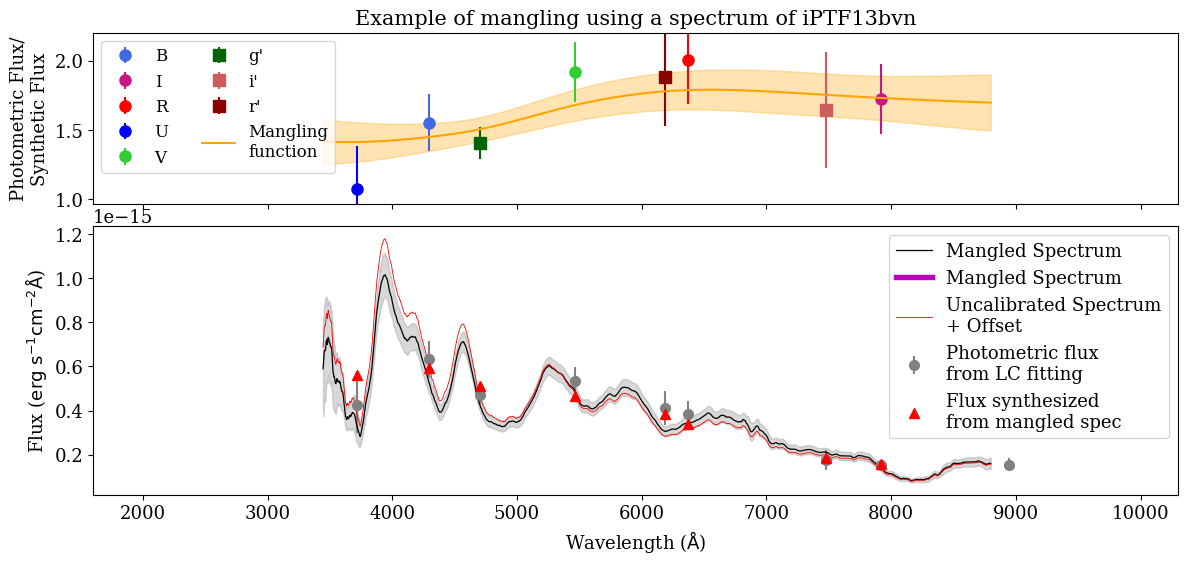

In [9]:
spec= SingleSpectrumClass(snname=snname, spec_file=list_[0], verbose=False)
spec.load_raw_spec()
result = spec.mangle_spectrum_function(show=True)

## Mangle ALL spectra and show the series of mangled specs
#### Results from each single mangling are shown in ./Outputs/SNname/mangled/

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_10459/1122813917.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return (integrate.trapezoid(transmission*flux*wls, wls)/\
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_10459/2143225095.py:131: RuntimeWarning: invalid value encountered in scalar divide
  raw_phot = integrate.trapezoid(filt_transm_interp_xLambda*cut_raw_spec['flux'], cut_raw_spec['wls'])/\
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_10459/2143225095.py:133: RuntimeWarning: invalid value encountered in scalar divide
  raw_phot_err = (integrate.trapezoid((filt_transm_interp_xLambda*cut_raw_spec['fluxerr'])**2,
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_10459/1122813917.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return (integrate.trapezoid(transmission*flux*wls, wls)/\
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_10459/2143225095.py:131: RuntimeWarning: invalid valu

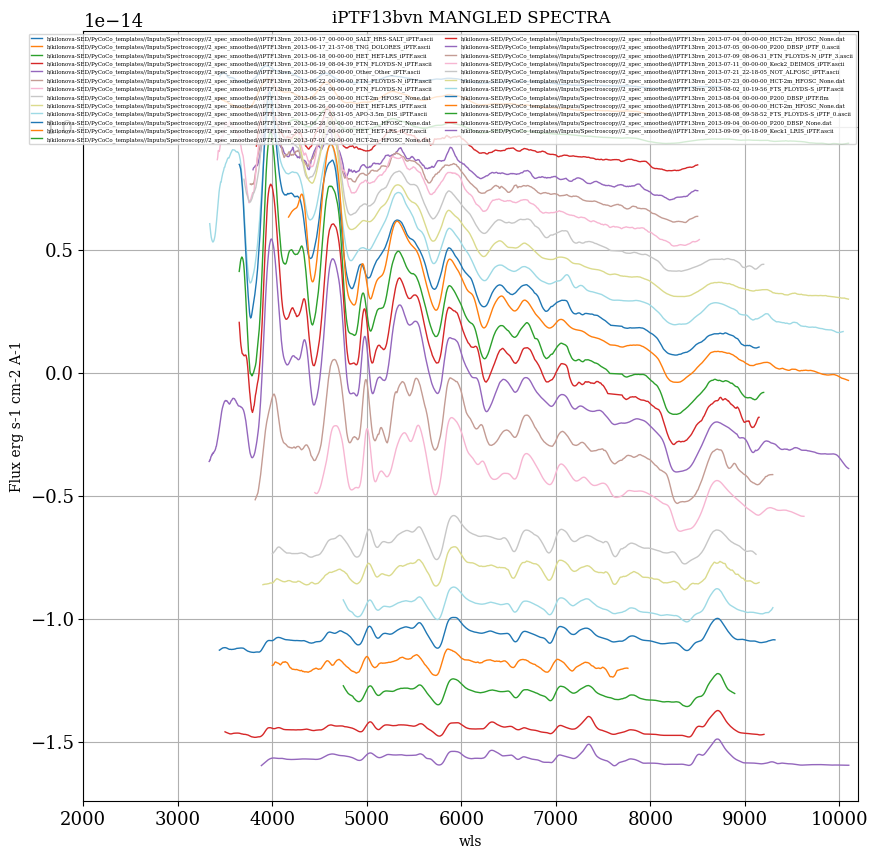

In [12]:
plot_all_mangledspecs(spec_class)